In [662]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [718]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7d85390a00a0>)

In [719]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [720]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [721]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 정제

In [722]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [723]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [724]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [725]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [726]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [727]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [728]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [729]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [730]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [731]:
print(len(train_data['document']))
print(len(train_data['label']))

145393
145393


In [732]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 토큰화

In [733]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [734]:
#############################################

In [735]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy
import sentencepiece as spm
import os

print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


In [736]:
temp_file_path = 'train_data.txt'
with open(temp_file_path, 'w', encoding='utf-8') as f:
    for doc in train_data['document']:
        f.write(doc + '\n') 

In [737]:
vocab_size = 16000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm_bpe --vocab_size={} --model_type=bpe'.format(temp_file_path, vocab_size)    
)

In [738]:
s = spm.SentencePieceProcessor()
s.Load('naver_review_spm_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[6928, 12264, 1328, 14458, 14552, 14452, 0]
['▁아버지가', '방에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [739]:
train_lst = []
for sentence in tqdm(train_data['document']):
#     tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    tokenized_sentence = s.SampleEncodeAsPieces(sentence,1, 0.0)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    train_lst.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [00:06<00:00, 21624.23it/s]


In [740]:
print(train_lst[:3])

[['▁아', '▁더빙', '▁진짜', '▁짜증나', '네요', '▁목소리'], ['▁흠', '포스터', '보고', '▁초딩', '영화', '줄', '오버', '연기', '조차', '▁가볍', '지', '▁않', '구나'], ['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다']]


In [741]:
test_lst = []
for sentence in tqdm(test_data['document']):
#     tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    tokenized_sentence = s.SampleEncodeAsPieces(sentence,1, 0.0)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    test_lst.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:02<00:00, 22042.66it/s]


In [742]:
print(len(train_lst))
print(len(test_lst))

145393
48852


In [743]:
corpus = train_lst[0]
tensor, word_index, index_word = sp_tokenize(s, corpus)

print("tensor:", tensor)
print("word_index:", word_index)
print("index_word:", index_word)

tensor: [[    6     0]
 [ 1019     0]
 [   50     0]
 [ 2293     0]
 [14450    35]
 [ 2010     0]]
word_index: {'<unk>': 0, '<s>': 1, '</s>': 2, '..': 3, '영화': 4, '▁영화': 5, '▁이': 6, '▁아': 7, '...': 8, '▁보': 9, '▁그': 10, '▁재': 11, 'ᄏᄏ': 12, '▁정': 13, '▁나': 14, '니다': 15, '는데': 16, '▁다': 17, '▁하': 18, '▁없': 19, '너무': 20, '▁좋': 21, '▁어': 22, '▁사': 23, '▁감': 24, '▁재미': 25, '▁진': 26, '▁연': 27, '▁너무': 28, '▁지': 29, '▁내': 30, '▁있': 31, '하고': 32, '!!': 33, '으로': 34, '▁최': 35, '지만': 36, '▁1': 37, '▁시': 38, '▁안': 39, '▁한': 40, '▁만': 41, '▁정말': 42, '▁스': 43, '네요': 44, '▁가': 45, '에서': 46, '....': 47, '▁재밌': 48, '▁기': 49, '▁평': 50, '▁봤': 51, '▁대': 52, '▁전': 53, '▁진짜': 54, '▁모': 55, '▁연기': 56, '▁마': 57, '하는': 58, '▁무': 59, '▁여': 60, '어요': 61, '▁수': 62, '▁잘': 63, '▁생': 64, '▁주': 65, '▁최고': 66, '▁않': 67, '▁더': 68, '▁평점': 69, '이다': 70, '▁개': 71, '드라': 72, '▁인': 73, '토리': 74, '습니다': 75, '▁제': 76, '▁이런': 77, '▁말': 78, '▁오': 79, '드라마': 80, '▁자': 81, '▁왜': 82, '하다': 83, '▁소': 84, '▁배': 85, '▁같': 86, '▁생각': 

In [744]:
print(train_lst[:1])
print(y_train[:1])

[['▁아', '▁더빙', '▁진짜', '▁짜증나', '네요', '▁목소리']]
[0]


In [745]:
print(len(train_lst))
print(len(y_train))

145393
145393


In [746]:
drop_train = [index for index, sentence in enumerate(train_lst) if len(sentence) < 1]
print(drop_train)

[]


In [747]:
# 빈 샘플들을 제거
X_train = np.delete(train_lst, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


145393
145393


리뷰의 최대 길이 : 99
리뷰의 평균 길이 : 12.703596459251822


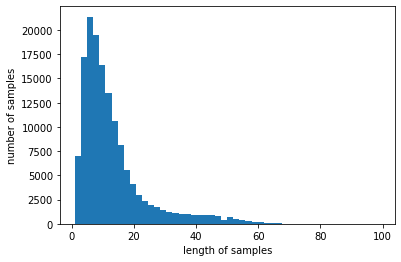

In [748]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [749]:
X_train

array([list(['▁아', '▁더빙', '▁진짜', '▁짜증나', '네요', '▁목소리']),
       list(['▁흠', '포스터', '보고', '▁초딩', '영화', '줄', '오버', '연기', '조차', '▁가볍', '지', '▁않', '구나']),
       list(['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다']), ...,
       list(['▁이게', '▁뭐', '요', '▁한국', '인은', '▁거', '먹', '거리고', '▁필', '리', '핀', '▁혼', '혈', '▁착']),
       list(['▁청춘', '▁영화의', '▁최고봉', '방', '황', '▁우울', '했던', '▁날', '들의', '▁자', '화', '상']),
       list(['▁한국', '▁영화', '▁최초로', '▁수', '간', '하는', '▁내용이', '▁담긴', '▁영화'])],
      dtype=object)

In [750]:
####
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('길이가 %s 이하 비율: %s'%(max_len, (count / len(nested_list))*100))


max_len = 30
below_threshold_len(max_len, X_train)
###

길이가 30 이하 비율: 91.95284504756074


In [751]:
X_tokenized = []
for text in X_train:
    X_tokenized.append(s.EncodeAsIds(str(text)))
####
X_tokenized = pad_sequences(X_tokenized, maxlen=max_len)
# X_test = pad_sequences(X_test, maxlen=max_len)
####
    

In [752]:
# Padding
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_tokenized, padding='pre')

In [753]:
X_padded.shape

(145393, 30)

In [754]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_train, test_size=0.2, random_state=40)

In [755]:
X_train[0].shape

(30,)

In [756]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 300
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)



Epoch 1/15
1454/1454 [==============================] - 10s 6ms/step - loss: 0.4885 - acc: 0.7594 - val_loss: 0.4290 - val_acc: 0.7973

Epoch 00001: val_acc improved from -inf to 0.79732, saving model to best_model.h5
Epoch 2/15
1454/1454 [==============================] - 8s 6ms/step - loss: 0.3772 - acc: 0.8324 - val_loss: 0.3911 - val_acc: 0.8218

Epoch 00002: val_acc improved from 0.79732 to 0.82182, saving model to best_model.h5
Epoch 3/15
1454/1454 [==============================] - 8s 6ms/step - loss: 0.3348 - acc: 0.8563 - val_loss: 0.3851 - val_acc: 0.8238

Epoch 00003: val_acc improved from 0.82182 to 0.82384, saving model to best_model.h5
Epoch 4/15
1454/1454 [==============================] - 8s 6ms/step - loss: 0.3048 - acc: 0.8717 - val_loss: 0.3934 - val_acc: 0.8222

Epoch 00004: val_acc did not improve from 0.82384
Epoch 5/15
1454/1454 [==============================] - 8s 6ms/step - loss: 0.2819 - acc: 0.8852 - val_loss: 0.4023 - val_acc: 0.8182

Epoch 00005: val_acc d